In [ ]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd drive/My \ Drive/Text_Summarization

except:
    print("No Colab Environment")

Drive already mounted at ./drive/; to attempt to forcibly remount, call drive.mount("./drive/", force_remount=True).
/content/drive/My  Drive/Text_Summarization


In [1]:
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns

# Load Data

In [2]:
df_overview = pd.read_csv("Data/processed/Clean_Lemma_LongForm_Telehealth.csv")
df_overview.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length,Clean_Content_Lemma,Clean_Content_Lemma_LongForm,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,36423,veteran face a variety of stressor relate to t...,veteran face a variety of stressor relate to t...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,The impact of the COVID-19 pandemic on the chi...,72009,the impact of the covid-19 pandemic on the chi...,the impact of the covid-19 pandemic on the chi...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,In November 2019 COVID-19—the infectious highl...,61640,"in November 2019 , covid-19 — the infectious ,...","in November 2019 , covid-19 — the infectious ,...",Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,29392,anxiety and depressive disorder be among the m...,anxiety and depressive disorder be among the m...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,In mid-March 2020 the authors—as well as the m...,41383,"in mid - March , 2020 , the author — as well a...","in mid - March , 2020 , the author — as well a...",Covid


## Pre and Post Covid Dataset

In [3]:
df_precovid = df_overview[df_overview["Classification"] == "Pre-Covid"]
df_covid = df_overview[df_overview["Classification"] == "Covid"]

## EDA

In [4]:
import matplotlib
import matplotlib.pyplot as plt

from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, PosTagVisualizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.rcParams["figure.figsize"] = (20, 7)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


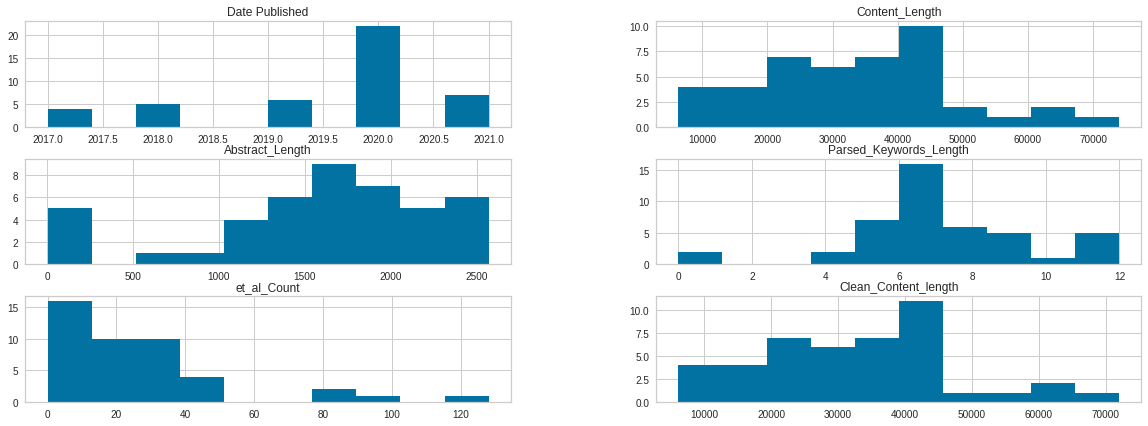

In [5]:
_ = df_overview.hist()

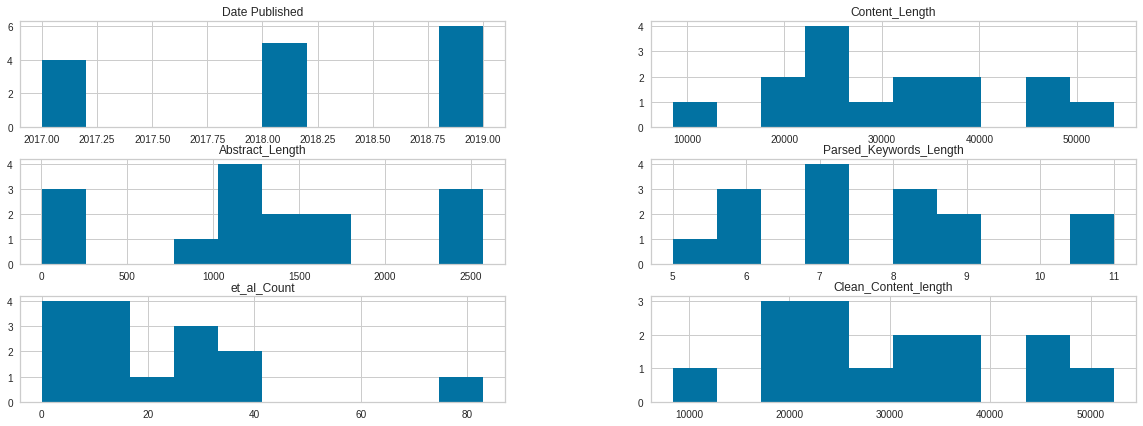

In [6]:
_ = df_precovid.hist()

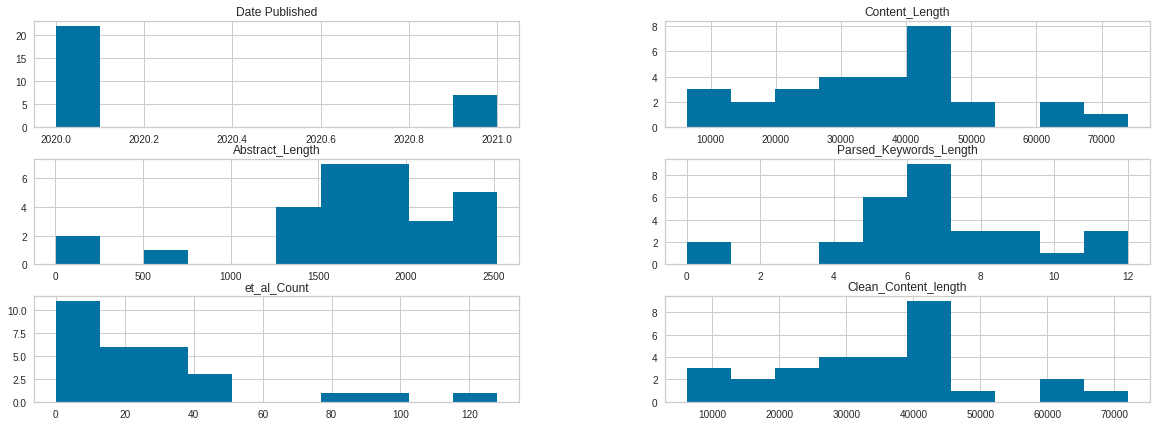

In [7]:
_ = df_covid.hist()

In [8]:
datasets = [df_overview,df_covid,df_precovid]
dataset_labels = ["Overview","During Covid","Pre-Covid"]

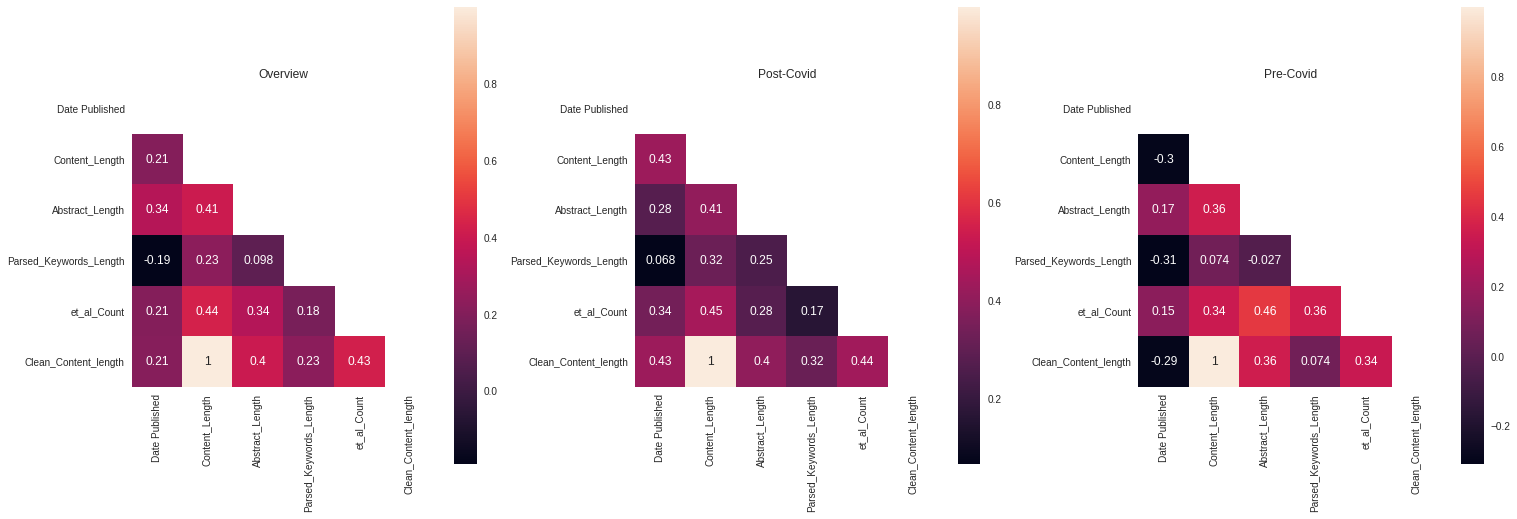

In [9]:
# There are not strong linear correlations between the lengths or Date Published

fig, ax = plt.subplots(1,3)

fig.tight_layout(h_pad=2,w_pad=8)

# datasets = [df_metadata,df_metadata_post_covid,df_metadata_pre_covid]
dataset_labels = ["Overview","Post-Covid","Pre-Covid"]

for index, dataset in enumerate(datasets):

    corr = dataset.corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr,ax=ax[index], annot=True,square=True,mask=mask)
    ax[index].set_title(f"{dataset_labels[index]}")


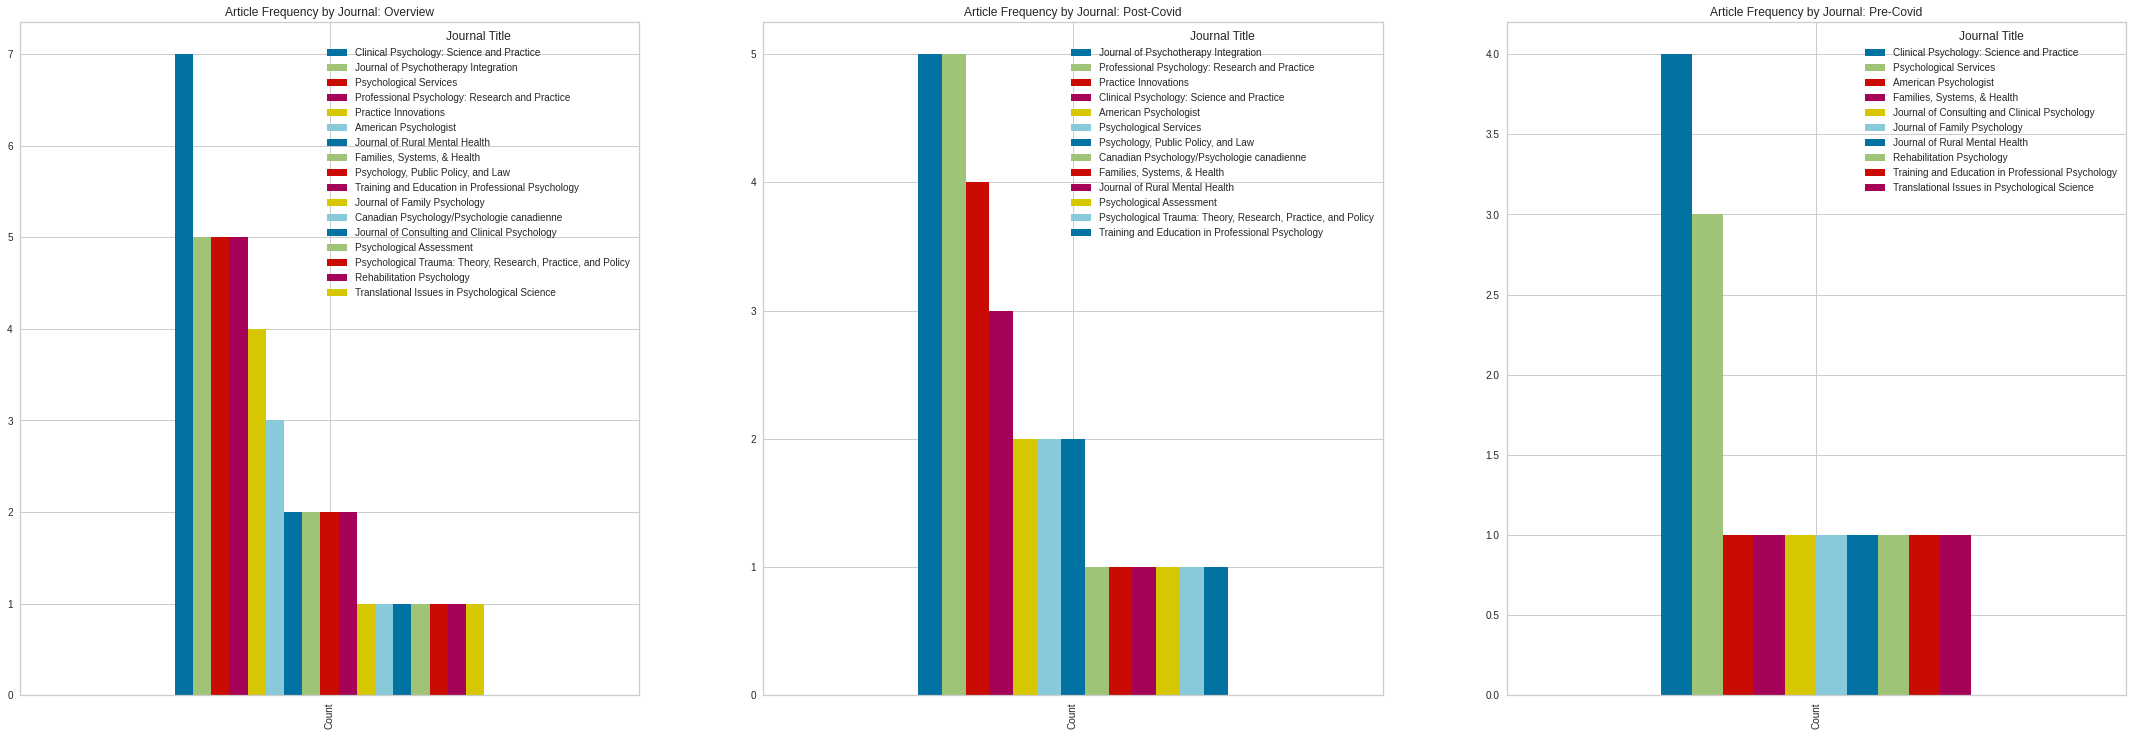

In [10]:
fig, ax = plt.subplots(1,3,figsize=(30,10))

fig.tight_layout(h_pad=2,w_pad=8)


for index, dataset in enumerate(datasets):

    dataset[["Journal Title","Content"]].rename(columns={"Content":"Count"}).groupby("Journal Title").count().sort_values("Count",ascending=False).T.plot(kind="bar"
    ,ax=ax[index]
    ,title=f"Article Frequency by Journal: {dataset_labels[index]}")
    

## Acronyms - Include as Vocabulary for Paper

In [11]:
import spacy

nlp = spacy.load("en_core_web_sm")

corpus = df_overview["Content"]

docs = list(nlp.pipe(corpus,disable=["tagger","parser","textcat"]))

## NER

In [12]:
ner_dictionary = dict()

ner_dictionary_count = dict()

ner_dictionary_document = dict()

#NER token with label
for index, doc in enumerate(docs):
    
    for ent in doc.ents:

        ner_dictionary[ent.text] = ent.label_

        #ner_dictionary_document[ent.text]  (ent.text,index)

        if ent.text in ner_dictionary_count.keys():
            ner_dictionary_count[ent.text] += 1
            ner_dictionary_document[ent.text].add(str(index))

        else:
            ner_dictionary_count[ent.text] = 0
            ner_dictionary_document[ent.text] = {str(index)}

In [14]:
with open("./references/abbreviation_table.json", "r") as r:
    
    abrv_dict = json.load(r)

#drop incorrect abbreviations
with open('./referencesIncorrect_abbrev.json', "r") as toremove:
  data = json.load(toremove)

for key in data.keys():
  abrv_dict.pop(key)

#fix inaccurate abbreviations
with open("./references/Abbreviation_corrections.json", "w") as outfile:
    
    json.dump(abrv_dict, outfile,indent=4)

In [15]:
ner_data = [ner_dictionary,ner_dictionary_count,ner_dictionary_document]
df_ner = pd.DataFrame(ner_data).T.reset_index().rename(columns={0:"NER_Label",1:"Count","index":"Term",2:"Document"}).sort_values("Count",ascending=False)

df_ner["Term_Long_Form"] = df_ner["Term"].apply(lambda x: abrv_dict[x] if x in abrv_dict.keys() else x)

df_ner["Document"] = df_ner["Document"].apply(lambda doc: " ".join(list(doc)))

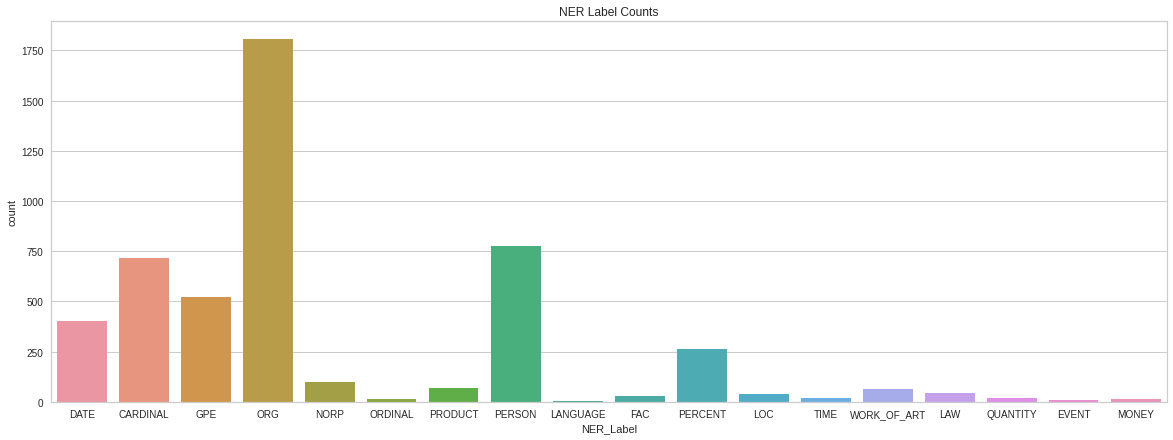

In [16]:
ax = sns.countplot(data=df_ner,x="NER_Label")
_ = ax.set_title("NER Label Counts")

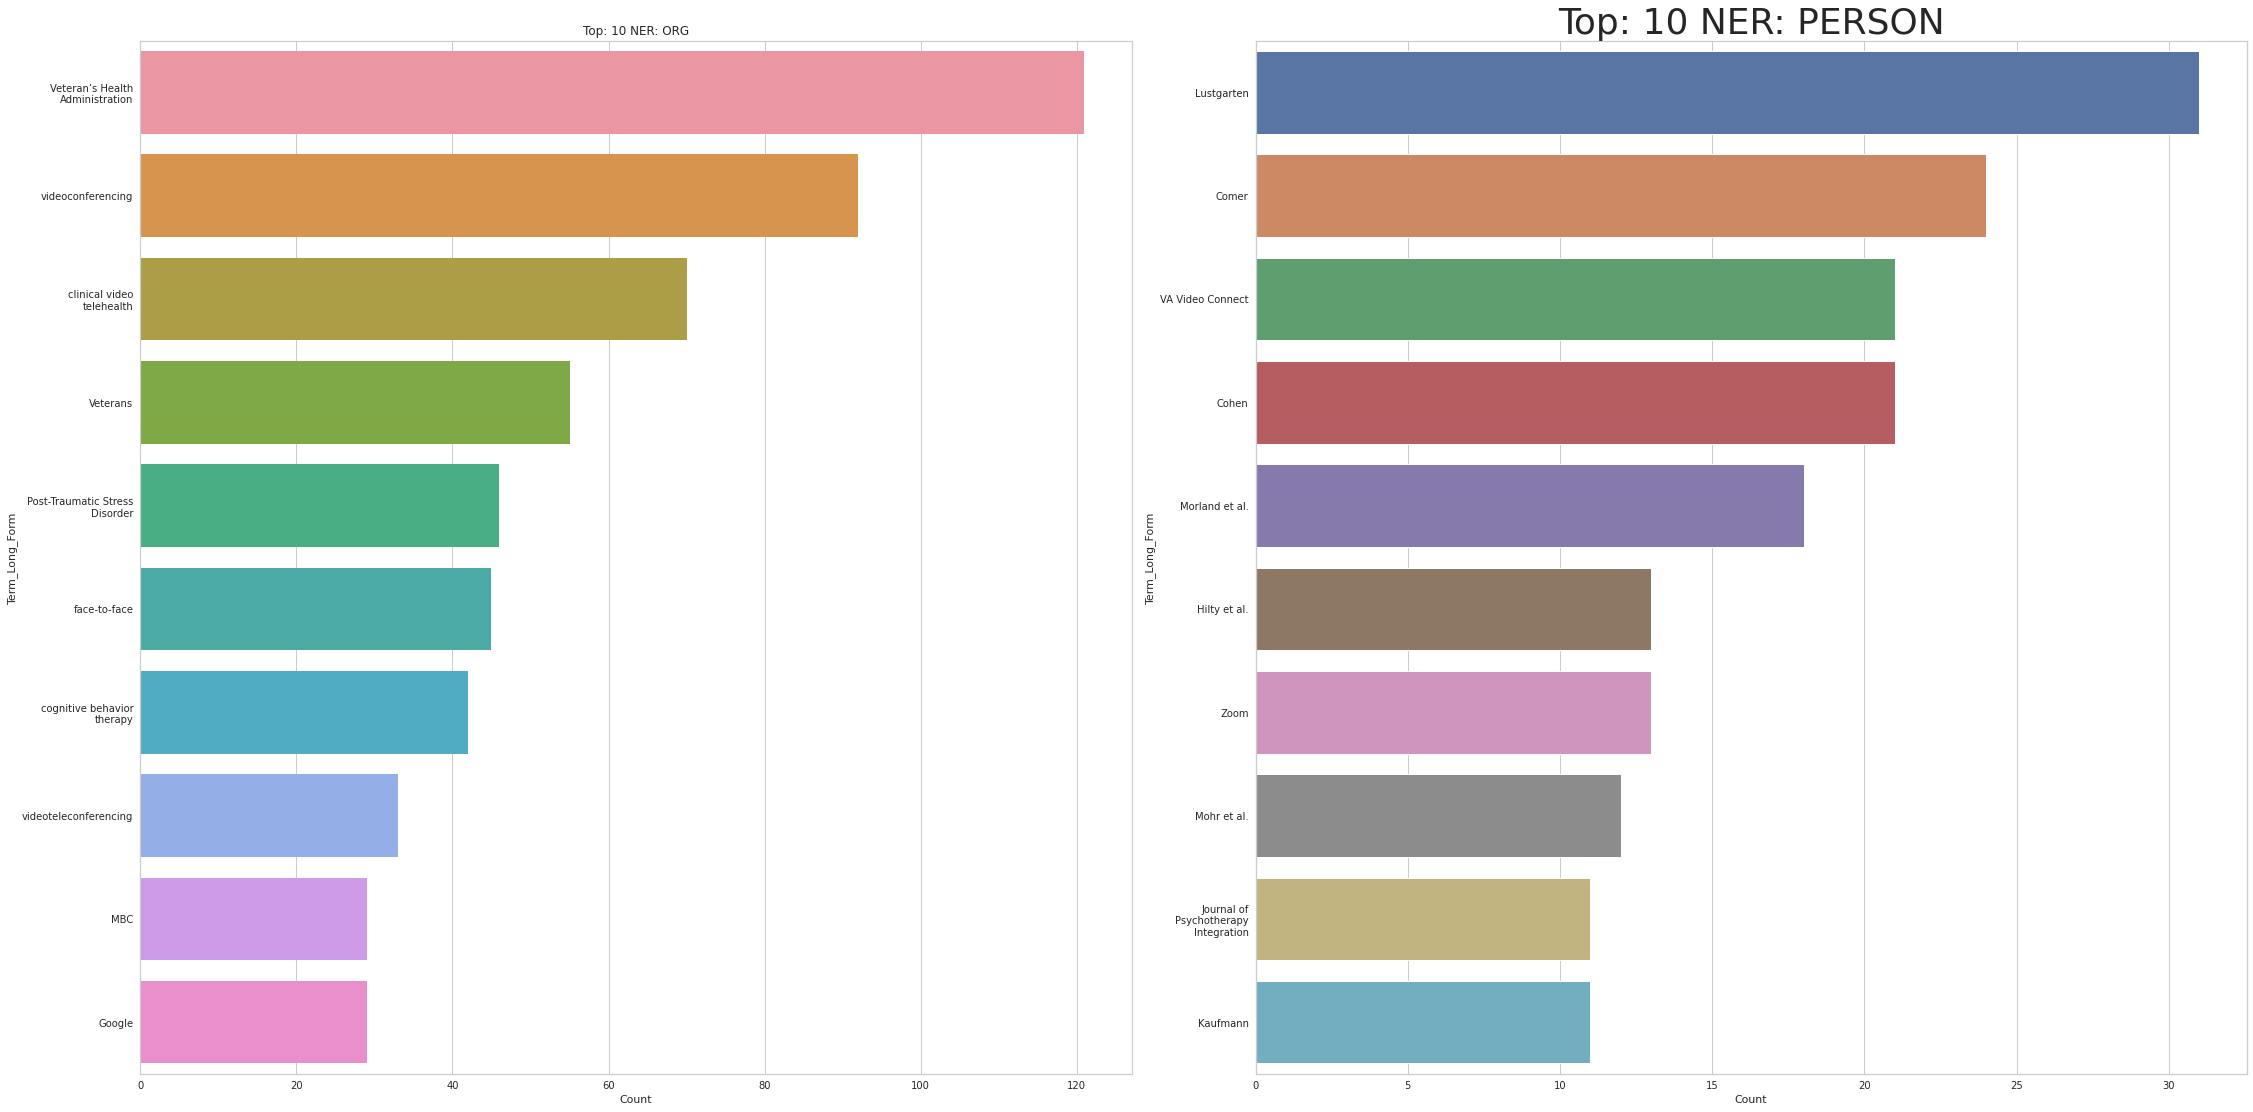

In [17]:
import textwrap

top = 10
visualize_cols = ["ORG","PERSON"]

fig, ax = plt.subplots(1,len(visualize_cols),figsize = (30,15))
fig.tight_layout(h_pad=2,w_pad=8)

for index,col in enumerate(visualize_cols):
    data = df_ner[df_ner["NER_Label"] == col][:10]
    _ = sns.barplot(data=data,x="Count",y="Term_Long_Form",ax=ax[index],orient="h")
    ax[index].set_title(f"Top: {top} NER: {col}")
    _ = sns.set(font_scale = 3)  
    ax[index].set_yticklabels([textwrap.fill(phrase, 21) for phrase in data["Term_Long_Form"].head(top)])

# Text Mining - frequency counts of words, length of sentences, presence/absence of specific words

In [18]:
def countplots(data,dataset_name,vectorizers,cols=4,):

    rows = len(vectorizers)
    cols = cols #dynamically change n_grams and plots

    fig, ax = plt.subplots(rows,cols,figsize=(30,15))
    fig.tight_layout(h_pad=2,w_pad=cols*4)

    for index, vect in enumerate(vectorizers):

        for i in range(cols):

            vectorizer = vect(stop_words=nlp.Defaults.stop_words,ngram_range=(i+1,i+1),lowercase=False)
            vectorizer_name = str(vectorizer)
            vectorizer_title = vectorizer_name[:vectorizer_name.find("(")]
            documents = vectorizer.fit_transform(data)
            features = vectorizer.get_feature_names()
            visualizer = FreqDistVisualizer(features=features, orient="H",n=10,ax=ax[index,i])
            ax[index,i].set_title(f"Dataset: {dataset_name} - {vectorizer_title} {vectorizer.ngram_range}")
            _ = visualizer.fit(documents)
            _ = sns.set(font_scale = 3)  
            #ax[index,i].set_yticklabels([textwrap.fill(phrase, 20) for phrase in data.head(10)])



# Keyword Extraction Based on Count



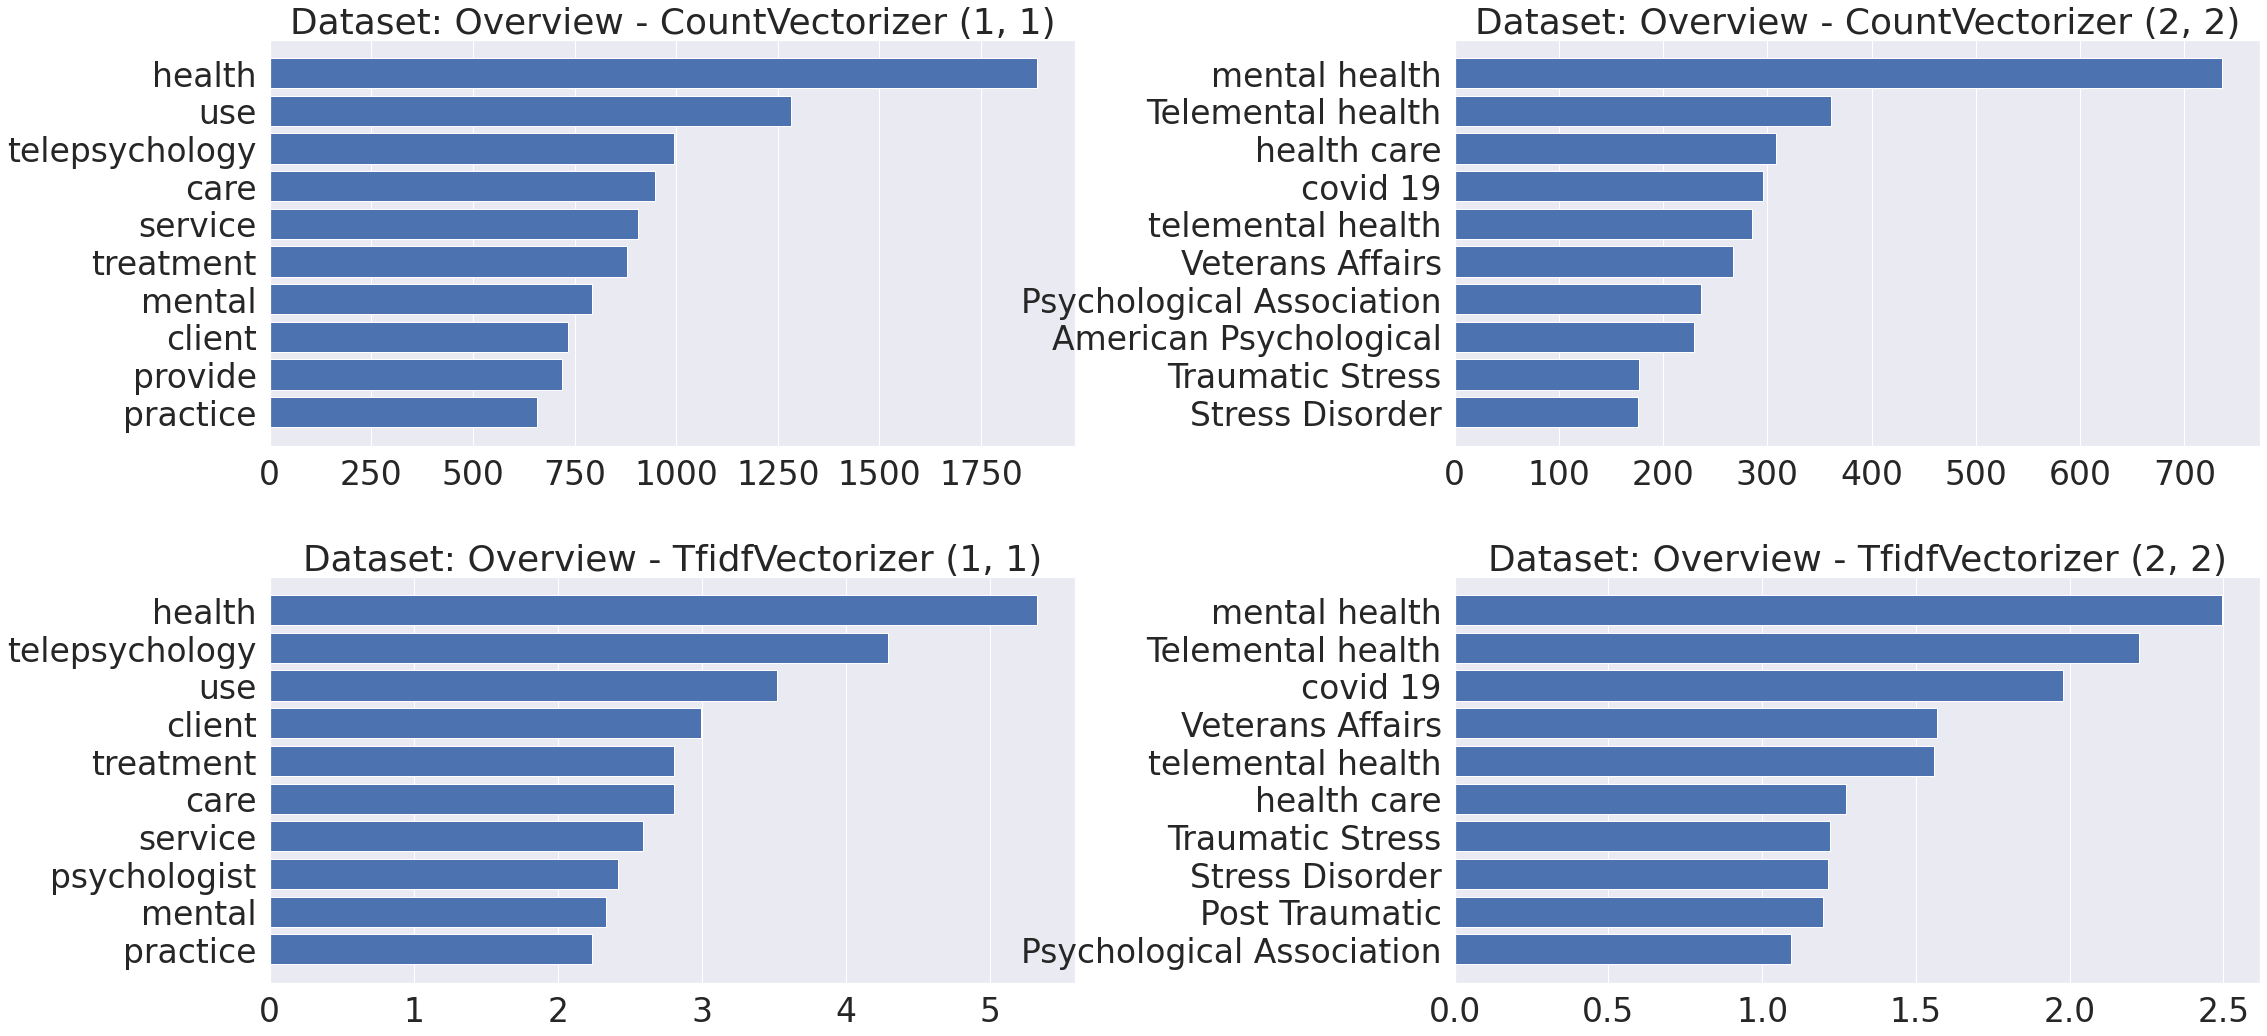

In [19]:
#Add stop words
nlp.Defaults.stop_words |= {"PRON","et","al","ll","ve"}

countplots(df_overview["Clean_Content_Lemma_LongForm"],"Overview",[CountVectorizer,TfidfVectorizer],cols=2)


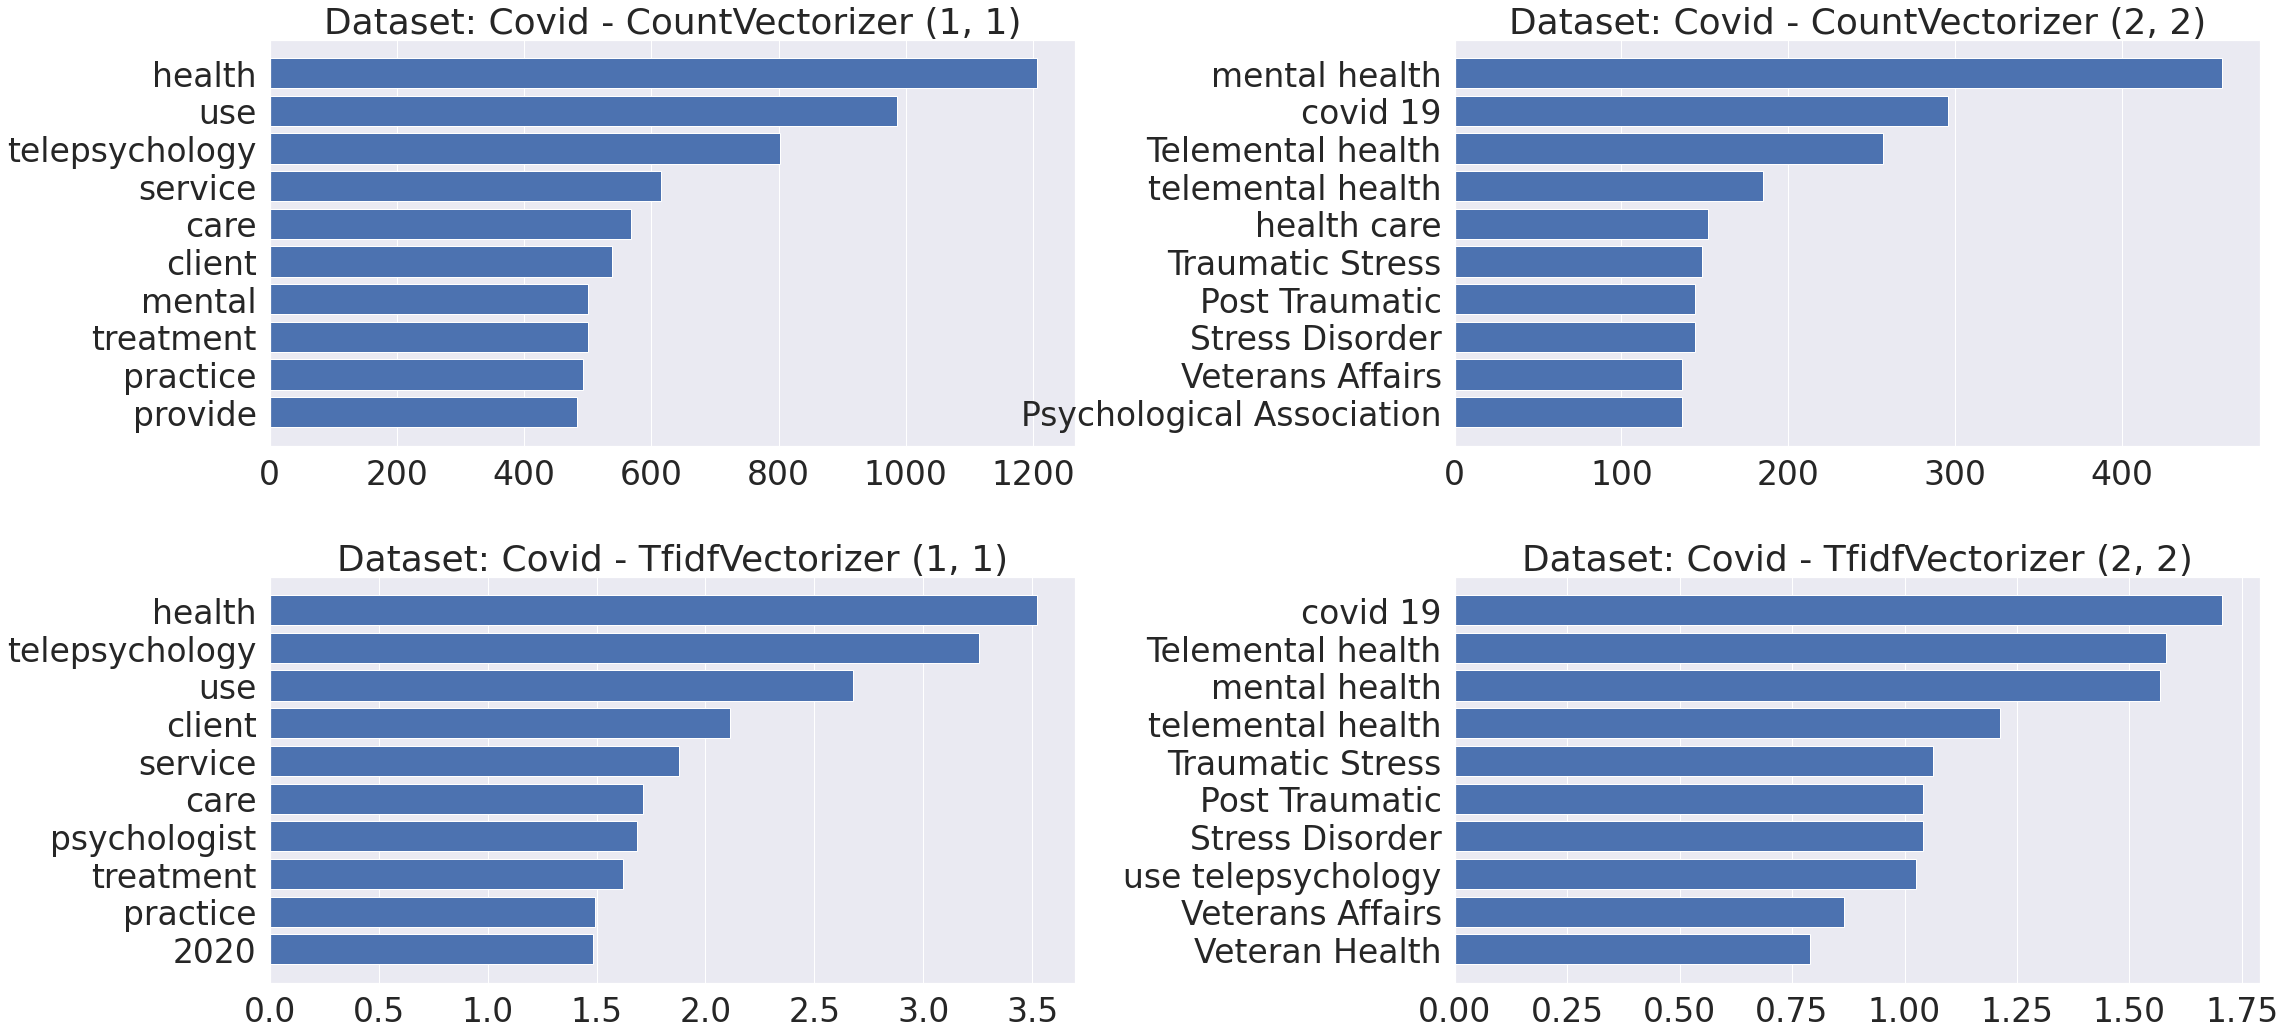

In [20]:
countplots(df_covid["Clean_Content_Lemma_LongForm"],"Covid",[CountVectorizer,TfidfVectorizer],cols=2)


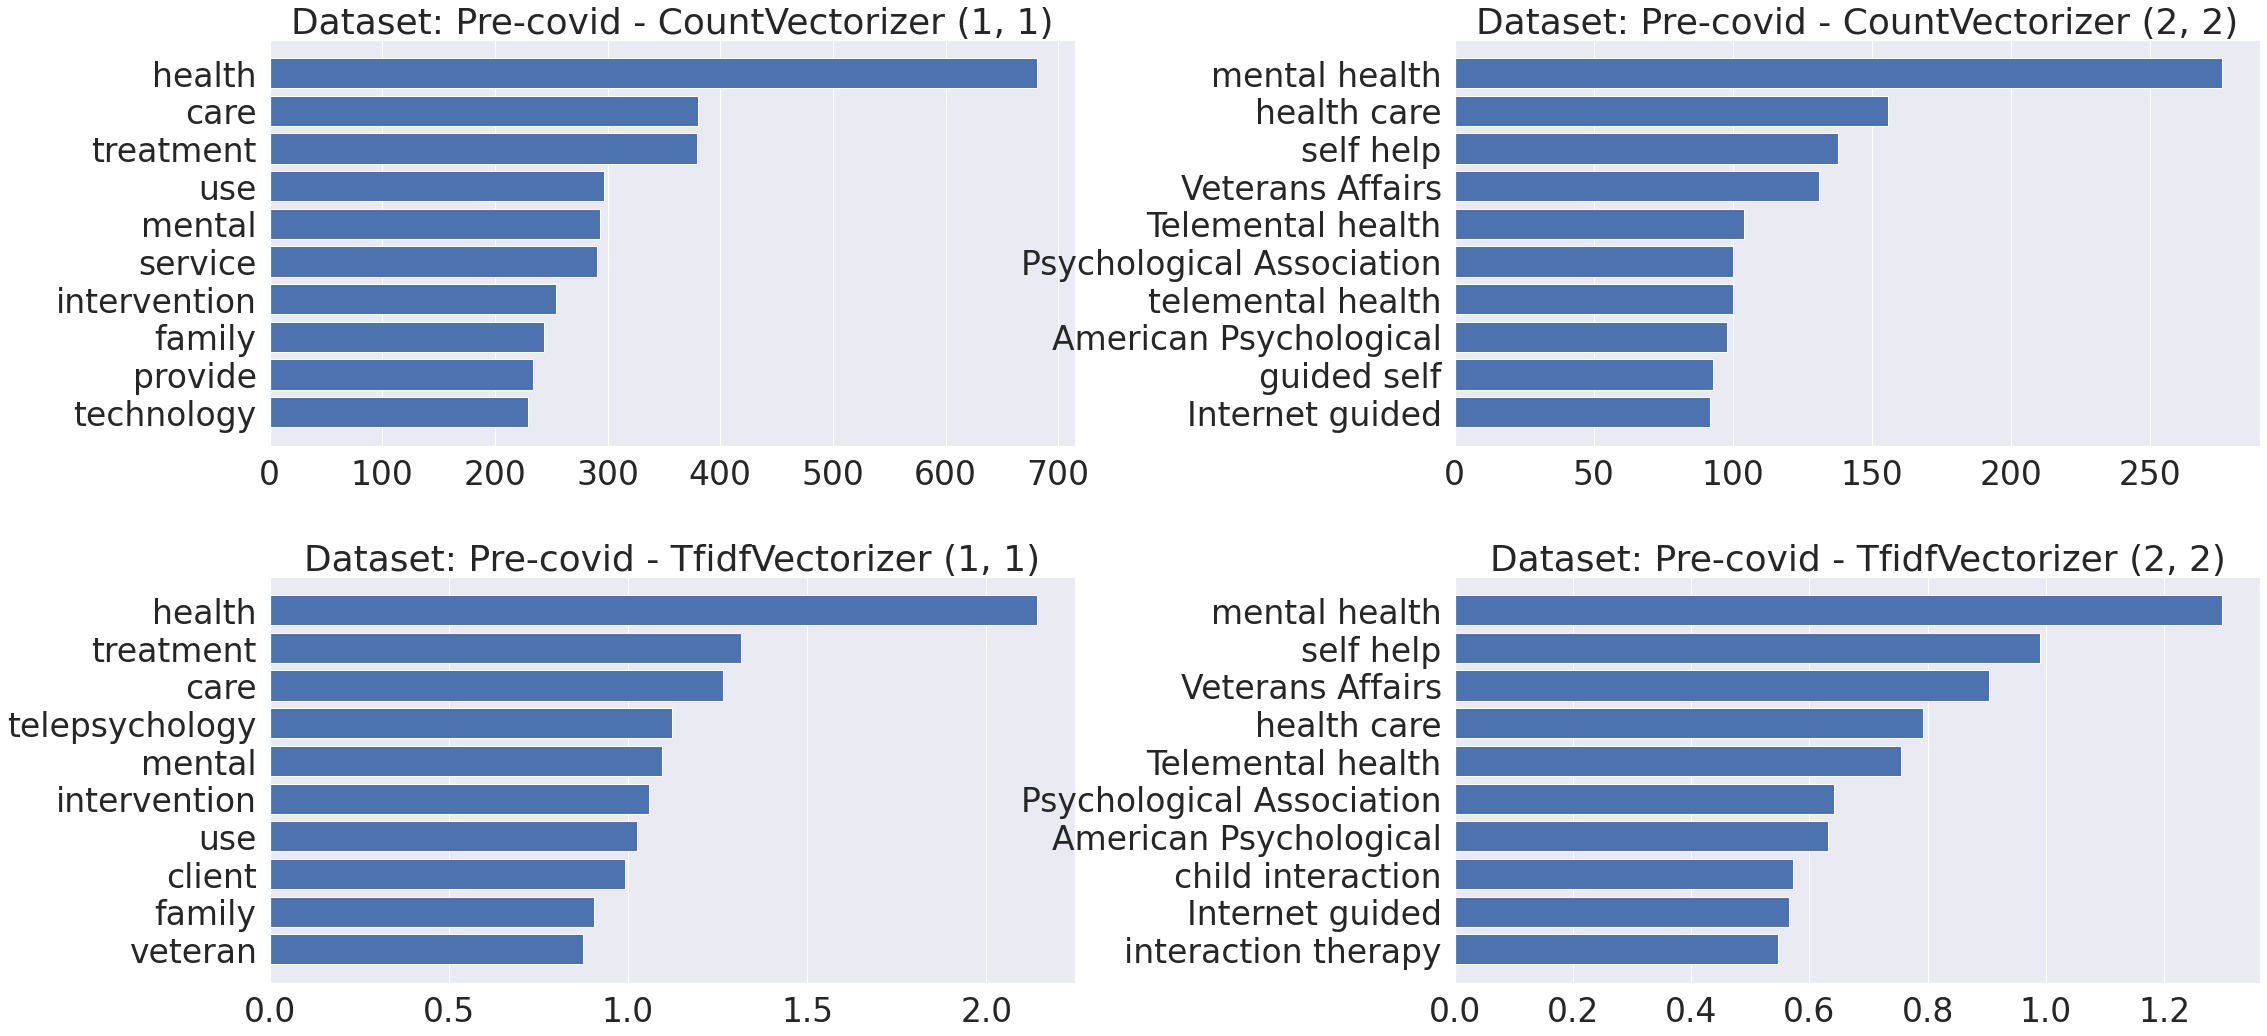

In [21]:
countplots(df_precovid["Clean_Content_Lemma_LongForm"],"Pre-covid",[CountVectorizer,TfidfVectorizer],cols=2)


# Keyword Extraction from Given Dataset - Count

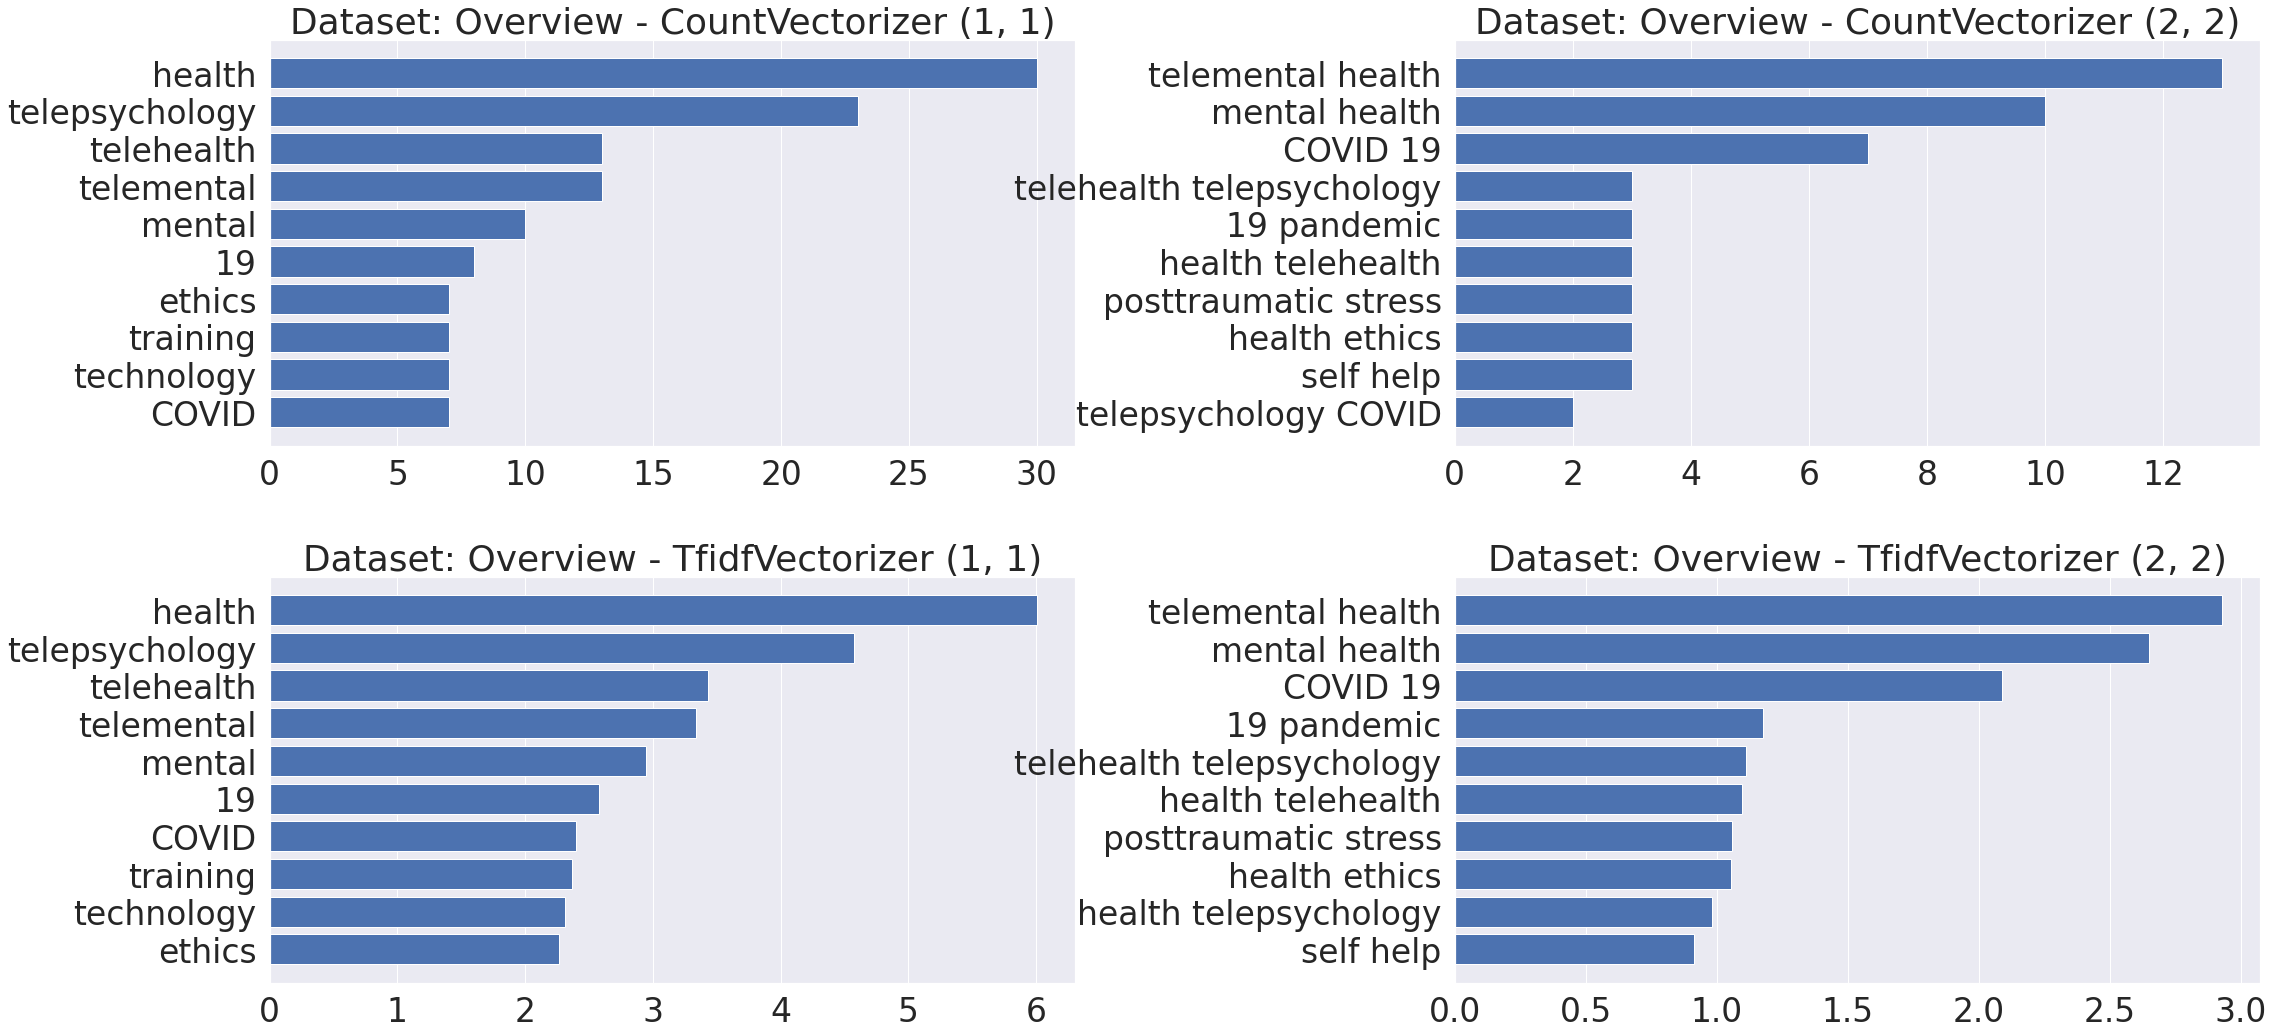

In [22]:
parsed_words = df_overview["Parsed_Keywords"].to_list()
countplots(parsed_words,"Overview",[CountVectorizer,TfidfVectorizer],cols=2)

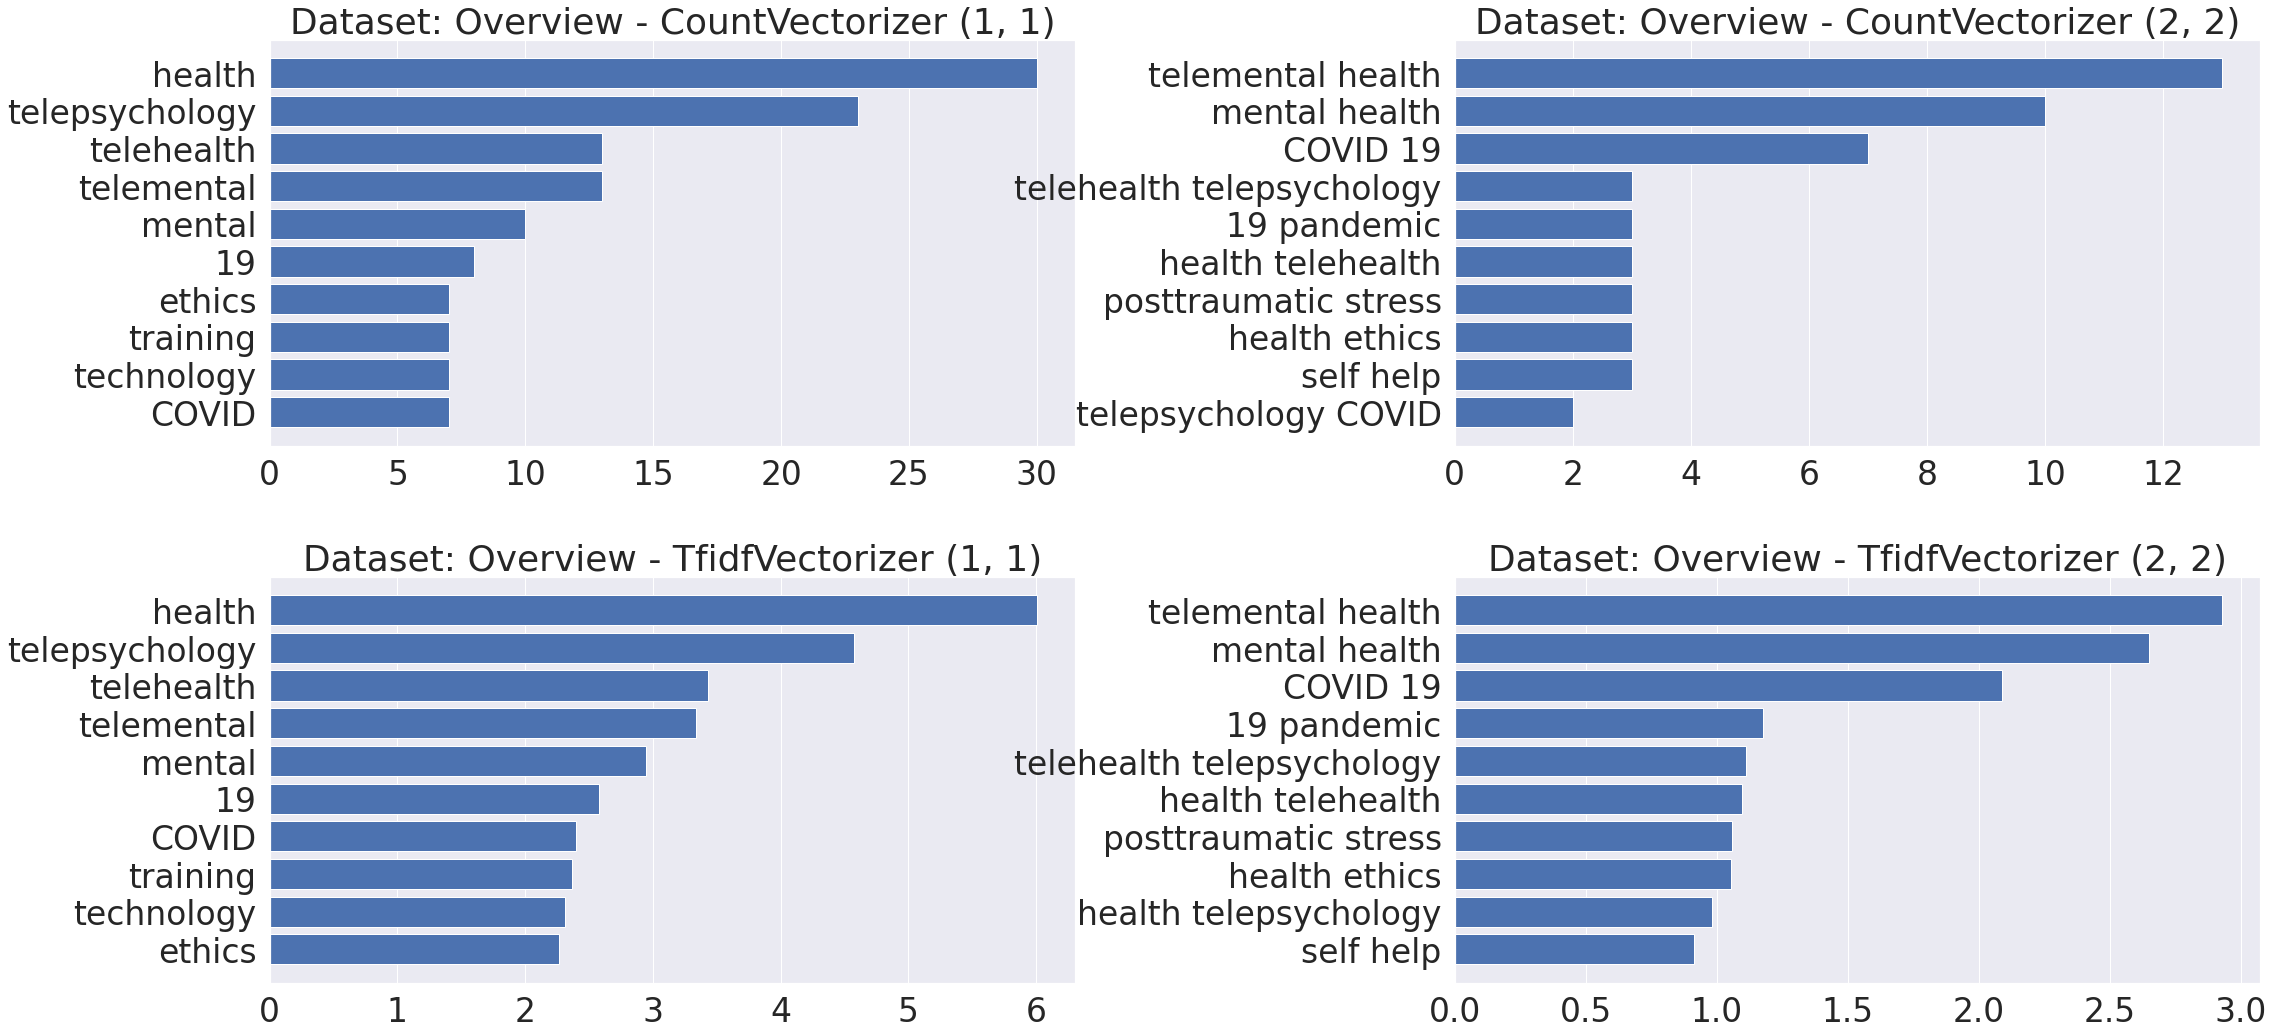

In [23]:
parsed_words = df_overview["Parsed_Keywords"].to_list()
countplots(parsed_words,"Overview",[CountVectorizer,TfidfVectorizer],cols=2)

## Keyword Extraction Gensim

In [48]:
import gensim
from gensim.summarization import keywords, mz_keywords
full_text = ''
for i in df_overview["Clean_Content_Lemma_LongForm"]:
  full_text = full_text + i
Overall_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
Overall1 = pd.DataFrame(Overall_Keywords)
Overall1.head()

,0,1
0,provider,0.192767
1,provide,0.192767
2,providers,0.192767
3,providence,0.192767
4,health,0.175086


In [49]:
Overall2 = pd.DataFrame(mz_keywords(full_text, scores=True, split = True, weighted=False, threshold=1.0))
Overall2.head()

/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:70: RuntimeWarning: divide by zero encountered in log2
  log_p = numpy.log2(p)
/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:71: RuntimeWarning: invalid value encountered in multiply
  h = numpy.nan_to_num(p * log_p).sum(axis=0)


,0,1
0,tbehavioral,3.846140
1,latinx,3.740481
2,binformation,3.659214
3,farmer,3.331147
4,telesupervision,3.295381


In [58]:
full_text = ''
for i in df_precovid["Clean_Content_Lemma_LongForm"]:
  full_text = full_text + i
Pre_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
pre1 = pd.DataFrame(Pre_Keywords)
pre2 = pd.DataFrame(mz_keywords(full_text,blocksize = 25, scores=True, split = True, weighted=False, threshold=.5))

/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:70: RuntimeWarning: divide by zero encountered in log2
  log_p = numpy.log2(p)
/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:71: RuntimeWarning: invalid value encountered in multiply
  h = numpy.nan_to_num(p * log_p).sum(axis=0)


In [51]:
full_text = ''
for i in df_covid["Clean_Content_Lemma_LongForm"]:
  full_text = full_text + i
Covid_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
covid1 = pd.DataFrame(Covid_Keywords)
covid2 = pd.DataFrame(mz_keywords(full_text, blocksize = 25, scores=True, split = True, weighted=False, threshold=.5))

/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:70: RuntimeWarning: divide by zero encountered in log2
  log_p = numpy.log2(p)
/usr/local/lib/python3.7/dist-packages/gensim/summarization/mz_entropy.py:71: RuntimeWarning: invalid value encountered in multiply
  h = numpy.nan_to_num(p * log_p).sum(axis=0)


In [55]:
covid2[0][:10].tolist

0              marriage
1                  blue
2    videoconferencingp
3                latino
4               medalia
5              umbrella
6              argument
7                 asian
8            bronchitis
9               dreyfus
Name: 0, dtype: object

In [59]:
data = {'Overall Keywords': Overall1[0][:10].to_list(), 'Overall MZ Keywords':Overall2[0][:10].to_list(), 'Prepandemic Keywords':pre1[0][:10].to_list(), 'Prepandemic MZ Keywords':pre2[0][:10].to_list(), 'Covid Keywords':covid1[0][:10].to_list(), 'Covid MZ Keywords': covid2[0][:10].tolist()}
data

{'Covid Keywords': ['provider',
  'provide',
  'providers',
  'clinically',
  'clinical',
  'clinic',
  'clinics',
  'use',
  'usefulness',
  'useful'],
 'Covid MZ Keywords': ['marriage',
  'blue',
  'videoconferencingp',
  'latino',
  'medalia',
  'umbrella',
  'argument',
  'asian',
  'bronchitis',
  'dreyfus'],
 'Overall Keywords': ['provider',
  'provide',
  'providers',
  'providence',
  'health',
  'clinically',
  'clinical',
  'clinic',
  'clinics',
  'use'],
 'Overall MZ Keywords': ['tbehavioral',
  'latinx',
  'binformation',
  'farmer',
  'telesupervision',
  'mbc',
  'tow',
  'respiratory',
  'v',
  'lower'],
 'Prepandemic Keywords': ['provide',
  'provider',
  'providence',
  'providers',
  'health',
  'include',
  'included',
  'treatment',
  'service',
  'services'],
 'Prepandemic MZ Keywords': ['cullum',
  'weiner',
  'grosch',
  'hynan',
  'postbaseline',
  'style',
  'pcit',
  'rotation',
  'face',
  'affairsmc']}

In [60]:
merged_df = pd.DataFrame(data=data)
merged_df

,Overall Keywords,Overall MZ Keywords,Prepandemic Keywords,Prepandemic MZ Keywords,Covid Keywords,Covid MZ Keywords
0,provider,tbehavioral,provide,cullum,provider,marriage
1,provide,latinx,provider,weiner,provide,blue
2,providers,binformation,providence,grosch,providers,videoconferencingp
3,providence,farmer,providers,hynan,clinically,latino
4,health,telesupervision,health,postbaseline,clinical,medalia
5,clinically,mbc,include,style,clinic,umbrella
6,clinical,tow,included,pcit,clinics,argument
7,clinic,respiratory,treatment,rotation,use,asian
8,clinics,v,service,face,usefulness,bronchitis
9,use,lower,services,affairsmc,useful,dreyfus


In [61]:
merged_df.to_csv('./Keywords.csv')

# Keyword Extraction NLTK Rake

In [31]:
!pip install rake-nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=d9404a938f11e9f7e84a63f3dded47c06152c63856d1ddfcf3c9e53059a5ef6e
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [32]:
from rake_nltk import Rake

keyword_corpus = " ".join(df_overview["Clean_Content_Lemma_LongForm"])

r_extraction = Rake()

r_extraction.extract_keywords_from_text(keyword_corpus)

In [33]:
r_extraction.get_ranked_phrases()[:10]

['2018 ). va nyh telemental health hub psychology servicethe veterans affairs ny harbor health care system',
 'veterans affairs nyh telemental health hub psychology servicethe veterans affairs nyh telemental health hub',
 'download slidelogistic regression 3a third logistic regression use binary predictor variable reflect focus',
 '2018 ). va new york harbor health care system — manhattan',
 'stand weekly veterans affairs nyh telemental health hub psychology staff peer supervision',
 '2014 ). training recommendationswe propose approach rural integrate behavioral health care inequity',
 'stand weekly veterans affairs nyh telemental health hub psychology staff meeting',
 'cognitive remediation could also improve neurocognitive functioning among defendant opine incompetent',
 'veterans affairs rocky mountain mental illness research education clinical centers',
 'servicesthe veterans affairs nyh telemental health hub psychology service utilize']

## Dispersion Plot - Based on Clean_Dataset (Not including abbreviation substitution)

In [34]:
#Troubleshooting tokens to remove
dispersion_text = [doc.split() for doc in df_metadata["Clean_Content_Lemma_LongForm"]]

#Choose words whose occurence in the text will be plotted:
not_found = ["1TABLESANDFIGUREstatefigure","AND FIGUREStatefigure"]
other_words = [token.split() for token in ["withinr","within"]]
other_words_1D = np.unique(np.concatenate(other_words).reshape(-1))
target_words = other_words_1D

#Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words,ignore_case=False)
_ = visualizer.fit(dispersion_text)

NameError: ignored

In [ ]:
#Make sure spacy is not splitting on - or else terms may be lost such as e-mental
temp_doc = nlp("forensic e-mental Mr. Davis")
#Lemma Removes e-mental
[(token.text,token.lemma_)for token in temp_doc]

In [ ]:
#df_metadata["emental_Found"] = df_metadata["Content"].apply(lambda text: text.find("forensic emental health"))

## NLP - Natural Language Processing is one of the components of text mining NLP helps identify sentiments, find entities in the sentence and categories of blogs/articles/posts. 

## In text analytics, statistical and machine learning algorithms are primarily used to (1) classify, cluster,and summarize information, (2) to perform sentiment analysis, entity extraction and recognition, as well as similarity analysis and relation modeling

## Keyword Extraction and Text Summarization

## Text Similarity

## Sentiment